## Sohu情感分析部分-数据分析

### 数据导入

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import functools

In [472]:
import ast
def text_to_df(mypath):
    output = pd.DataFrame(pd.read_csv(mypath,sep='\t',header=None).iloc[:,0].apply(ast.literal_eval).tolist())
    return output

In [269]:
#df:单文本多实体
df_train = text_to_df('Data/nlp_data/train.txt')
df_test = text_to_df('Data/nlp_data/test.txt')

In [473]:
#由generate_data.py构建
#df2:单文本单实体，1对1
df2_train = text_to_df('generated_train_data.txt')
df2_test = text_to_df('generated_test_data.txt')

In [175]:
#当有多个实体时，generated_xxx_data.txt会将一个内容按实体拆成复数个，如果在测试集中会分别对应label
#train.txt 89195
#generated_train_data.txt 206281
#test.txt 26766
#generated_test_data.txt 55949

s-generated_test_data.txt


In [192]:
df_train.head()

,id,content,entity
0,1,3.新疆棉是全球业界公认的高品质天然纤维原料，较好满足了全球范围内对棉制纺织品服装的刚性消费...,"{'美国': 0, '中国': 0}"
1,2,显然，与其指望德约在罗兰-加洛斯击败纳达尔，不如把希望寄托在墨尔本，寄托在梅德韦杰夫身上。去...,"{'德约': -1, '梅德韦杰夫': 1, '澳网': 0, '冠军': 0}"
2,3,选择Tips：露背连衣裙露肤元素是女性穿裙必备，只不过在选择这些性感元素的时候，尺寸一定要拿...,{'高圆圆': 1}
3,4,丰一吟：我父亲特别尊重弘一法师，他的恩师。他对别人说话有时还笑笑，但是提到法师的时候，都是很...,"{'弘一': 0, '护生画集': 0}"
4,5,近期，马斯克公开反对征收“富人税”，并透露自己已经缴了很多税。今年，特斯拉市值突破了1万亿美...,"{'马斯克': 0, '市值': 0}"


In [340]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89195 entries, 0 to 89194
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           89195 non-null  int64 
 1   content      89195 non-null  object
 2   entity       89195 non-null  object
 3   len_content  89195 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.7+ MB


In [244]:
df_train.isnull().sum()

id             0
content        0
entity         0
len_content    0
dtype: int64

In [191]:
df_test.head()

,id,content,entity
0,5000001,然而作为同龄的选手，王涵也不想把所有的压力都压在施廷懋一人的肩上，“当然我也可以给予她一些帮...,"[施廷懋, 王涵]"
1,5000002,◆诺贝尔奖是如何评选的据诺贝尔奖委员会官网介绍，诺贝尔奖由瑞典发明家、企业家阿尔弗雷德·诺贝...,"[阿尔弗雷德·诺贝尔, 诺贝尔奖委员会]"
2,5000003,上半场比赛中威少这边的进攻状态依旧不是太好，只不过对比威少以往的表现，这场比赛威少的进攻也算...,"[威少, 约基奇, 詹姆斯, 霍华德, 半场]"
3,5000004,虽然大家对“网红”这类人诟病不断，但依旧阻挡不了网络直播的蓬勃发展，各式各样的网红还是像雨后...,"[刘祥坤, 二龙湖, 热度]"
4,5000005,然而，支持小沈龙认为大米没有问题的网友寥寥无几。有网友评论“小沈龙太缺德，给本山老师丢脸”“...,"[小沈龙, 粉丝, 明星]"


In [219]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26766 entries, 0 to 26765
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       26766 non-null  int64 
 1   content  26766 non-null  object
 2   entity   26766 non-null  object
dtypes: int64(1), object(2)
memory usage: 627.5+ KB


In [216]:
df_test.isnull().sum()

id         0
content    0
entity     0
dtype: int64

In [245]:
df2_train.head()

,id,content,entity,label
0,1,3.新疆棉是全球业界公认的高品质天然纤维原料，较好满足了全球范围内对棉制纺织品服装的刚性消费...,美国,0
1,1,3.新疆棉是全球业界公认的高品质天然纤维原料，较好满足了全球范围内对棉制纺织品服装的刚性消费...,中国,0
2,2,显然，与其指望德约在罗兰-加洛斯击败纳达尔，不如把希望寄托在墨尔本，寄托在梅德韦杰夫身上。去...,德约,-1
3,2,显然，与其指望德约在罗兰-加洛斯击败纳达尔，不如把希望寄托在墨尔本，寄托在梅德韦杰夫身上。去...,梅德韦杰夫,1
4,2,显然，与其指望德约在罗兰-加洛斯击败纳达尔，不如把希望寄托在墨尔本，寄托在梅德韦杰夫身上。去...,澳网,0


### 预处理

In [487]:
#去除符号：输入句子，输出句子
def clear_character(sentence):    
    pattern = re.compile("[^\u4e00-\u9fa5^a-z^A-Z^0-9]")  #只保留中英文和数字
    #替换为[^\u4e00-\u9fa5^,^.^!^a-z^A-Z^0-9]  #只保留中英文、数字和符号，去掉其他东西
    line=re.sub(pattern,' ',sentence)  #把文本中匹配到的字符替换成空格符
    new_sentence=' '.join(line.split())    #去除空白
    return new_sentence

In [ ]:
#jieba分词：输入句子，输出list
import jieba
def jieba_fenci(sentence):
    seg_list = jieba.cut(sentence,cut_all=False)
    seg_list = ' '.join(seg_list)
    jieba_word_list = [i for i in seg_list.split(' ')if i != '']
    return jieba_word_list

In [ ]:
#去除停用词，加载停用词词典：输入list，输出list
stopwords = open('Data/cn_stopwords.txt')
stopwords_text = stopwords.read()
stopwords.close()
stopwords_list = stopwords_text.split('\n')
print ("We use " + str(len(stopwords_list)) + " stop-words from cn_stopwords library.")
def remove_stopwords(seg_list):
    stop_words_list = stopwords_list  
    seg_filtered = []
    for word in seg_list:
        if word not in stopwords_list:
            seg_filtered.append(word)
    return seg_filtered

In [535]:
#对功能的封装：输入句子，返回list，每个list都是句子经过预处理后的产物
def processing(sentence):
    sentence = clear_character(sentence) #去除符号
    jieba_list = jieba_fenci(sentence) #jieba分词
    filtered_list = remove_stopwords(jieba_list) #去停用词
    return filtered_list

In [548]:
df_train['words'] = df_train['content'].apply(processing) 
df_test['words'] = df_test['content'].apply(processing) 

In [1195]:
df_train.to_json("Data/nlp_data/processed_train.json")
df_test.to_json("Data/nlp_data/processed_test.json")


In [558]:
df2_train['words'] = df2_train['content'].apply(processing) 
df2_test['words'] = df2_test['content'].apply(processing) 

In [469]:
df2_train.to_json("Data/nlp_data/generated_train.json")
df2_test.to_json("Data/nlp_data/generated_test.json")

NameError: name 'df2_train' is not defined

In [369]:
read_json = pd.read_json("Data/nlp_data/generated_train.json")
read_json.info()

In [468]:
df2_train.head()

NameError: name 'df2_train' is not defined

### 特征构造

In [321]:
#content列文本长度
df_train['len_content'] = df_train['content'].apply(lambda x: len(x)) 
df_test['len_content'] = df_test['content'].apply(lambda x: len(x)) 
df2_train['len_content'] = df2_train['content'].apply(lambda x: len(x)) 
df2_test['len_content'] = df2_test['content'].apply(lambda x: len(x)) 
#content列词数
df_train['word_counts']=df_train['words'].apply(lambda x: len(x)) 
df_test['word_counts'] = df_test['words'].apply(lambda x: len(x)) 

In [723]:
#每个content中entity实体个数
df_train['entity_num'] = df_train['entity'].apply(lambda x: len(x))
df_test['entity_num'] = df_test['entity'].apply(lambda x: len(x))

In [746]:
#entity列表
df_train['entity_list'] = df_train['entity'].apply(lambda x:(list(x.keys())))
#每个entity对应的情感极性标签列表
df_train['label_list'] = df_train['entity'].apply(lambda x:(list(x.values())))

In [1093]:
#计算label中每个值出现的频次
def label_count(lst):
    freq_dict = {}
    for x in lst :
        freq_dict[x] = freq_dict.get(x, 0) + 1
    return freq_dict
df_train['temp'] = df_train['label_list'].apply(lambda x:label_count(x))
df_temp = pd.concat([df_train.drop(['temp'], axis=1), df_train['temp'].apply(pd.Series)], axis=1)
df_temp = df_temp.fillna(0)
df_train = df_temp

In [1116]:
#计算同一文本中的label是否为同向
def same_dir(series):
    neg = series[-2]+series[-1]
    pos = series[2]+series[1]
    if neg > 0 and pos > 0:
        same = 0
    else:
        same = 1
    return same
df_train['label_same_dir'] = df_temp.apply(same_dir,axis=1)

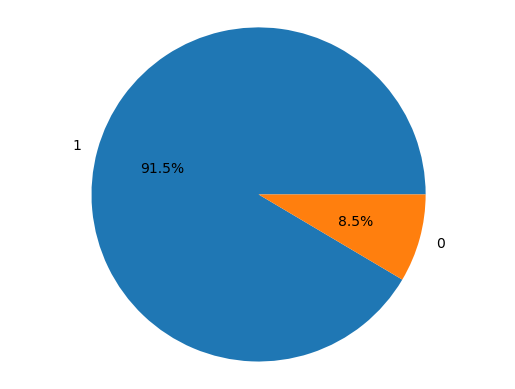

In [1153]:
#复数目标实体的标签方向是否相同
dt=df_train[df_train['entity_num']>1]['label_same_dir']
dt_count=dt.value_counts()  
dt_dict=dt_count.to_dict()
# Pie Plot
plt.pie(dt_dict.values(),labels=dt_dict.keys(),autopct='%1.1f%%')
plt.axis('equal')
plt.savefig("Figures/labels_dir.png")
plt.show()

In [ ]:
#每个content的总情感极性（label平均值）
df_train['label_mean_cat'] = df_train['label_list'].apply(lambda x: round(np.mean(x)))
#每个content的总情感极性（snownlp sentiments）
from snownlp import SnowNLP
df2_test['snow_sentiment'] = df2_test['content'].apply(lambda x: SnowNLP(x).sentiments) 
#df2_train['snow_sentiment'] = df2_train['content'].apply(lambda x: SnowNLP(x).sentiments) 

#### 每个content的情感词计数
基于词典，大连理工大学https://github.com/ZaneMuir/DLUT-Emotionontology

In [1165]:
df_dl = pd.read_excel('Data/情感词汇.xlsx')
df_dl = df_dl[['词语', '词性种类', '情感分类', '强度', '极性']]

In [1168]:
#按照七大情绪划分，但是只使用Positive和Negative
Happy = []
Good = []
Surprise = []
Anger = []
Sad = []
Fear = []
Disgust = []
for idx, row in df_dl.iterrows():
    if row['情感分类'] in ['PA', 'PE']:
        Happy.append(row['词语'])
    if row['情感分类'] in ['PD', 'PH', 'PG', 'PB', 'PK']:
        Good.append(row['词语']) 
    if row['情感分类'] in ['PC']:
        Surprise.append(row['词语'])     
    if row['情感分类'] in ['NA']:
        Anger.append(row['词语'])    
    if row['情感分类'] in ['NB', 'NJ', 'NH', 'PF']:
        Sad.append(row['词语'])
    if row['情感分类'] in ['NI', 'NC', 'NG']:
        Fear.append(row['词语'])
    if row['情感分类'] in ['NE', 'ND', 'NN', 'NK', 'NL']:
        Disgust.append(row['词语'])
Positive = Happy + Good +Surprise
Negative = Anger + Sad + Fear + Disgust
print('情绪词语列表整理完成')     

情绪词语列表整理完成


In [1187]:
def emotion_caculate(text):
    positive = 0
    negative = 0
    anger = 0
    disgust = 0
    fear = 0
    sad = 0
    surprise = 0
    good = 0
    happy = 0
    wordlist = jieba.lcut(text)
    wordset = set(wordlist)
    wordfreq = []
    for word in wordset:
        freq = wordlist.count(word)
        if word in Positive:
            positive+=freq
        if word in Negative:
            negative+=freq
    emotion_info = {
        'emotion_counts':positive+negative,
        'positive': positive,
        'negative': negative,
    }
    indexs = ['emotion_counts', 'positive', 'negative']
    return pd.Series(emotion_info, index=indexs)
emotion_caculate(text='这个国家再对这些制造假冒伪劣食品药品的人手软的话，那后果真的会相当糟糕。坐牢？从快判个死刑')

emotion_counts    4
positive          0
negative          4
dtype: int64

In [1188]:
from pandarallel import pandarallel
#并行初始化
pandarallel.initialize()
start = time.time()   
emotion_dftest = df_test['content'].parallel_apply(emotion_caculate)
emotion_dftrain = df_train['content'].parallel_apply(emotion_caculate)
end = time.time()
print(end-start)


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
4053.583652973175


In [1181]:
test_temp = pd.concat([df_test, emotion_dftest], axis=1)
train_temp = pd.concat([df_train, emotion_dftrain], axis=1)


In [1257]:
df_train['word_counts']=df_train['words'].apply(lambda x: len(x)) 

In [ ]:
#计算情感词占整个文本的占比
def emo_pct(series):
    emo_cnt = series["emotion_counts"]
    word_cnt = series["word_counts"]
    pct = emo_cnt/word_cnt
    return pct
df_train["emotion_percent"] = df_train.apply(emo_pct,axis=1)
df_test["emotion_percent"] = df_test.apply(emo_pct,axis=1)

In [1265]:
#Get information for label vs emotion counts
label_sent = df_train[['id','label_list','emotion_counts','positive','negative','emotion_percent']]
label_sent.head()

,id,label_list,emotion_counts,positive,negative,emotion_percent
0,1,"[0, 0]",27,22,5,0.157895
1,2,"[-1, 1, 0, 0]",9,9,0,0.097826
2,3,[1],11,8,3,0.203704
3,4,"[0, 0]",19,12,7,0.136691
4,5,"[0, 0]",1,1,0,0.026316


In [1266]:
label_sent = label_sent.explode('label_list')
label_sent['label_list'].value_counts()

 0    147565
 1     30367
-1     19080
-2      6981
 2      2288
Name: label_list, dtype: int64

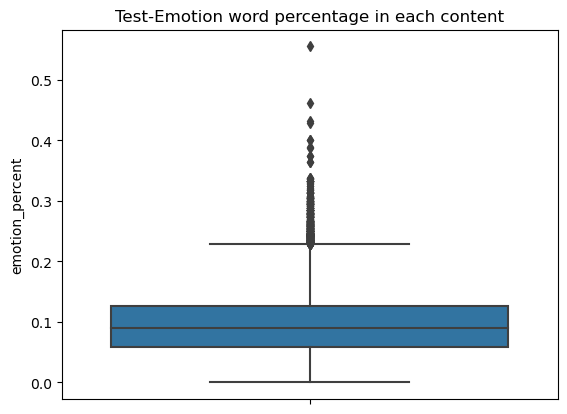

In [1282]:
plot=sns.boxplot(y=df_test['emotion_percent']);
plot.set(title = "Test-Emotion word percentage in each content")
fig = plot.get_figure()
fig.savefig("Figures/emo_pct_test.png")

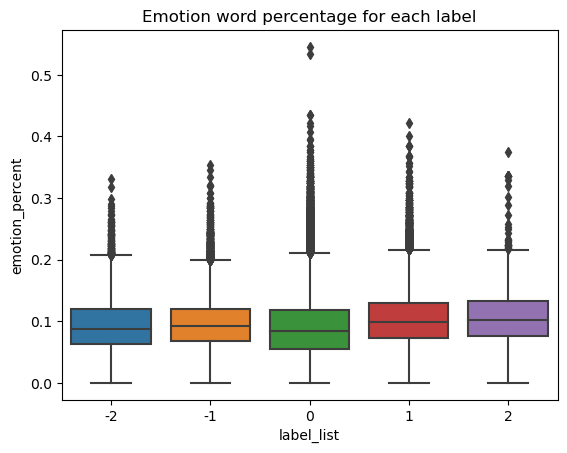

In [1275]:
plot=sns.boxplot(x=label_sent["label_list"], y=label_sent['emotion_percent']);
plot.set(title = "Emotion word percentage for each label")
fig = plot.get_figure()
fig.savefig("Figures/emo_pct_lab.png")

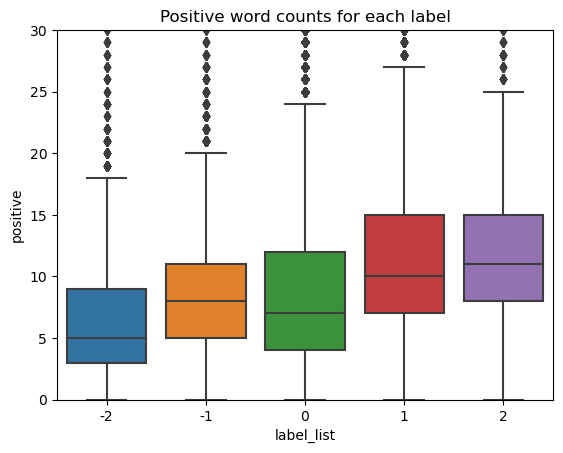

In [1270]:
plot=sns.boxplot(x=label_sent["label_list"], y=label_sent["positive"])
plot.set(title = "Positive word counts for each label")
plt.ylim(0, 30)
plt.savefig("Figures/sent_cnt_pos_30.png")
plt.show()
#fig = plot.get_figure()
#fig.savefig("Figures/sent_cnt_pos.png")

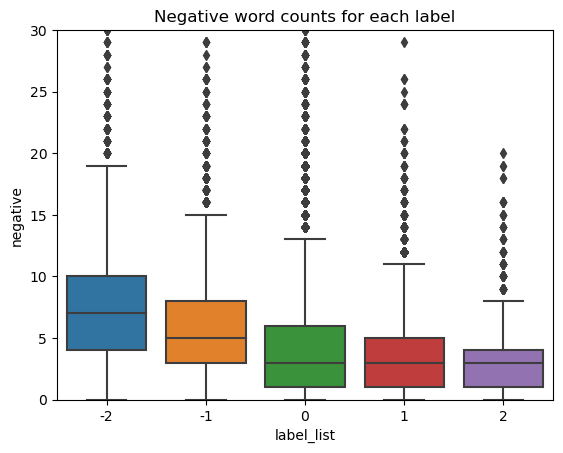

In [1271]:
plot=sns.boxplot(x=label_sent["label_list"], y=label_sent["negative"])
plot.set(title = "Negative word counts for each label")
plt.ylim(0, 30)
plt.savefig("Figures/sent_cnt_neg_30.png")
plt.show()
#fig = plot.get_figure()
#fig.savefig("Figures/sent_cnt_neg.png")

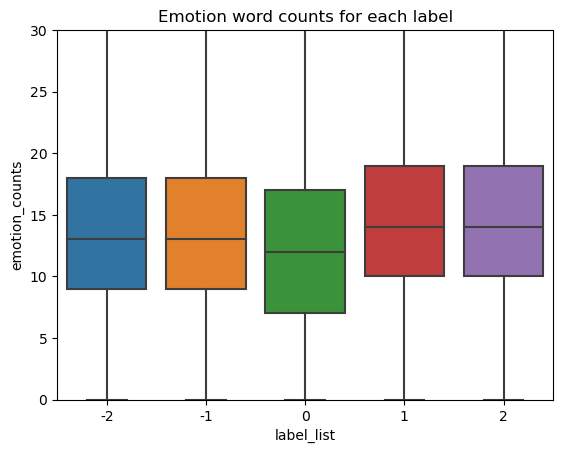

In [1272]:
plot=sns.boxplot(x=label_sent["label_list"], y=label_sent["emotion_counts"])
plot.set(title = "Emotion word counts for each label")
plt.ylim(0, 30)
plt.savefig("Figures/sent_cnt_30.png")
plt.show()

In [1277]:
test_emo = df_test[['id','emotion_counts','positive','negative','emotion_percent']]

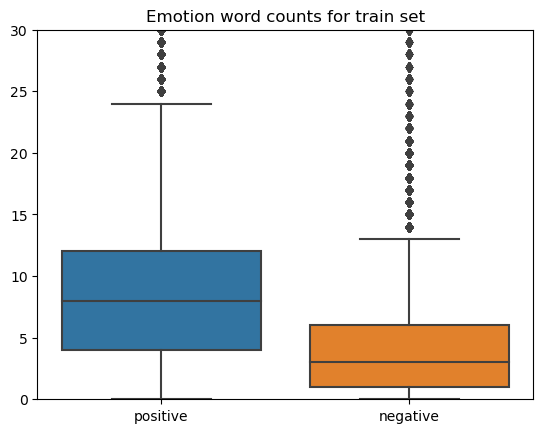

In [1286]:
plot=sns.boxplot(data=label_sent.iloc[:,3:5])
plot.set(title = "Emotion word counts for train set")
plt.ylim(0, 30)
plt.savefig("Figures/sent_cnt_train_30.png")
plt.show()

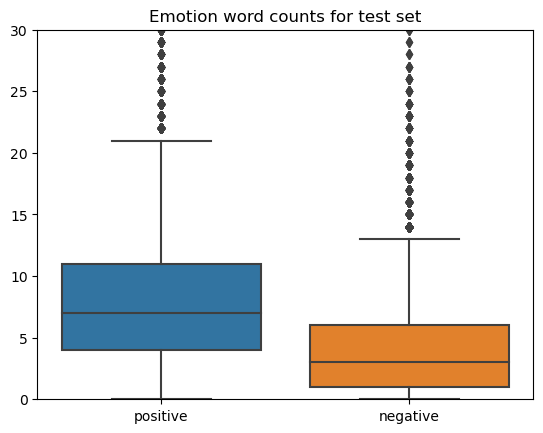

In [1285]:
plot=sns.boxplot(data=test_emo.iloc[:,2:4])
plot.set(title = "Emotion word counts for test set")
plt.ylim(0, 30)
plt.savefig("Figures/sent_cnt_test_30.png")
plt.show()

In [1422]:
label_sent.head()

,id,label_list,emotion_counts,positive,negative,emotion_percent
0,1,0,27,22,5,0.157895
0,1,0,27,22,5,0.157895
1,2,-1,9,9,0,0.097826
1,2,1,9,9,0,0.097826
1,2,0,9,9,0,0.097826


In [1322]:
#简单logistic regression分类测试
import sklearn
from sklearn.model_selection import cross_val_score
col = ['positive','negative']
x = label_sent[col]
y = label_sent['label_list']
x_train,x_test,y_train,y_test = sklearn.model_selection.train_test_split(x,y,test_size=0.2,random_state=1)
#scores = cross_val_score(lr,x_train,y_train,cv=10,scoring='accuracy')


In [1323]:
y_train= y_train.astype('int')
y_test= y_test.astype('int')

In [1445]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='multinomial',solver='sag',max_iter=1000)
#For multiclass problems, only 'newton-cg', 'sag', 'saga' and 'lbfgs' handle multinomial loss
lr.fit(x_train,y_train) 
score = lr.score(x_train,y_train)
print('训练集准确率：',score)
#模型在测试集上的得分
test_score = lr.score(x_test,y_test)
print('验证集准确率：',test_score)

训练集准确率： 0.7117631374830328
验证集准确率： 0.715345274741256


In [1447]:
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score(lr.predict(x_train), y_train, average='macro' )
print('训练集macro-f1：',f1)
f1_1 = f1_score(lr.predict(x_test), y_test, average='macro' )
print('验证集macro-f1：',f1_1)

训练集macro-f1： 0.1723167720700452
验证集macro-f1： 0.17282170268586922


In [1329]:
lr_test=df_test
lr_test=lr_test.explode('entity')

In [1332]:
x = lr_test[col]
lr_test['label_predict']=lr.predict(x)
lr_test['label_predict'].value_counts()

### 调整权重

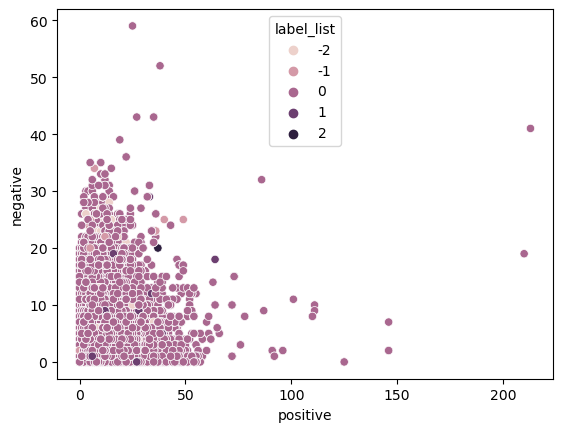

In [1430]:
#plt.xlim(0, 50)
#plt.ylim(0, 50)
sns.scatterplot(x="positive", y="negative", hue='label_list', data=label_sent)
plt.show()

In [1442]:
label_sent.to_csv("Data/label_sent.csv",index=False)

In [ ]:
from sklearn.utils import class_weight
class_weight =class_weight.compute_class_weight('balanced,np.unique(target_Y),target_Y)
model = LogisticRegression(class_weight = class_weight)
model.fit(X,target_Y)
# ['balanced', 'calculated balanced', 'normalized'] arehyperpaameterswhic we can play with.

### 生成线上提交txt

In [1349]:
lr_res=lr_test[['id','entity','label_predict']]

In [1410]:
lr1=lr_res.iloc[:,0:2]
def ab(df):
    return list(map(str,(','.join(df.values).split(','))))
lr1 = lr1.groupby(['id'])['entity'].apply(ab)
lr1 = lr1.reset_index()
lr1.head()

,id,entity
0,5000001,"[施廷懋, 王涵]"
1,5000002,"[阿尔弗雷德·诺贝尔, 诺贝尔奖委员会]"
2,5000003,"[威少, 约基奇, 詹姆斯, 霍华德, 半场]"
3,5000004,"[刘祥坤, 二龙湖, 热度]"
4,5000005,"[小沈龙, 粉丝, 明星]"


In [1409]:
lr2=lr_res[['id','label_predict']]
lr2['label_predict']= lr2['label_predict'].astype('str')
def cd(df):
    return list(map(int,(','.join(df.values).split(','))))
lr2 = lr2.groupby(['id'])['label_predict'].apply(cd)
lr2 = lr2.reset_index()
lr2.head()

/var/folders/s8/sh2pw2j53j93yx3bxdd8zld00000gn/T/ipykernel_6569/2708545653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr2['label_predict']= lr2['label_predict'].astype('str')


,id,label_predict
0,5000001,"[0, 0]"
1,5000002,"[0, 0]"
2,5000003,"[0, 0, 0, 0, 0]"
3,5000004,"[0, 0, 0]"
4,5000005,"[0, 0, 0]"


In [1412]:
df_res = pd.merge(lr1, lr2, on="id")
df_res.head()

,id,entity,label_predict
0,5000001,"[施廷懋, 王涵]","[0, 0]"
1,5000002,"[阿尔弗雷德·诺贝尔, 诺贝尔奖委员会]","[0, 0]"
2,5000003,"[威少, 约基奇, 詹姆斯, 霍华德, 半场]","[0, 0, 0, 0, 0]"
3,5000004,"[刘祥坤, 二龙湖, 热度]","[0, 0, 0]"
4,5000005,"[小沈龙, 粉丝, 明星]","[0, 0, 0]"


In [1417]:
def combine(series):
    entity = series["entity"]
    label = series["label_predict"]
    res_dict = dict(zip(entity,label))
    return res_dict
df_res["result"] = df_res.apply(combine,axis=1)
df_res = df_res[['id','result']]

In [1421]:
df_res.to_csv('lr-section1.txt',sep='\t',index=False)

### 实体Entity

In [901]:
#实体自身字段情感性（snownlp sentiments）
df2_train['entity_sentiment'] = df2_train['entity'].apply(lambda x: SnowNLP(x).sentiments) 
df2_test['entity_sentiment'] = df2_test['entity'].apply(lambda x: SnowNLP(x).sentiments) 
#stats.spearmanr(df2_train['label'],df2_train['entity_sentiment'])
#SpearmanrResult(correlation=-0.009644907829391014, pvalue=1.1834438294898743e-05)

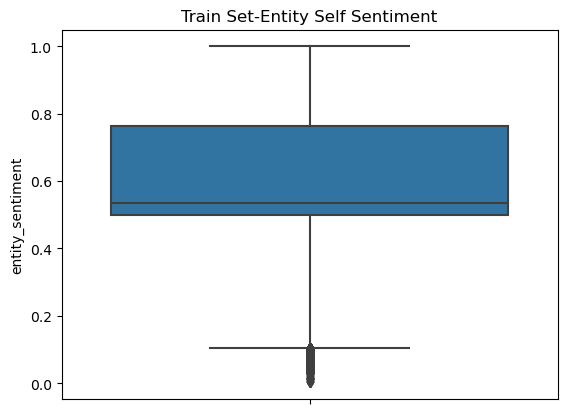

In [925]:
plot=sns.boxplot(y=df2_train['entity_sentiment'])
plot.set(title = "Train Set-Entity Self Sentiment")
fig = plot.get_figure()
fig.savefig("Figures/Entity_self_sentiment_Train.png")

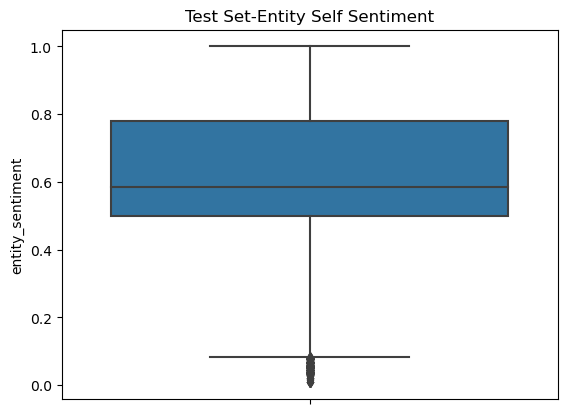

In [929]:
plot=sns.boxplot(y=df2_test['entity_sentiment'])
plot.set(title = "Test Set-Entity Self Sentiment")
fig = plot.get_figure()
fig.savefig("Figures/Entity_self_sentiment_Test.png")

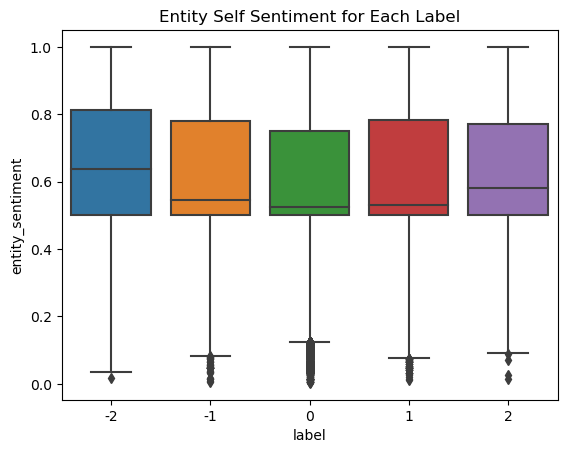

In [923]:
plot=sns.boxplot(x=df2_train['label'],y=df2_train['entity_sentiment'])
plot.set(title = "Entity Self Sentiment for Each Label")
fig = plot.get_figure()
fig.savefig("Figures/Entity_self_sentiment.png")

In [1010]:
#应用百度LAC判断entity词性（人名、地名等）-->太慢
from LAC import LAC
def lac_pos(word):
    lac = LAC(mode='lac')
    lac_result = lac.run(word)[1]
    return lac_result[0]
df2_test['lac_pos']=df2_test['entity'].apply(lac_pos)


In [ ]:
plt.figure(figsize=(10, 5))
dplot = sns.histplot(df2_test['lac_pos'])
dplot.set(title = "Test Data - Entity Part of Speech - LAC")
fig = dplot.get_figure()
fig.savefig("Figures/entity_pos_test_lac.png")

In [1044]:
len(df2_test['lac_pos'].unique())

22

In [1022]:
print(df2_test[df2_test['lac_pos']=='']['entity'])

51880    小昭昭昭昭昭昭昭昭昭
Name: entity, dtype: object


In [975]:
#应用jieba判断entity词性（人名、地名等）
import jieba.posseg as pseg
def jieba_pos(text):
    words = pseg.cut(text)
    for word, flag in words:
        return flag
df2_train['entity_pos']=df2_train['entity'].apply(jieba_pos)
df2_test['entity_pos']=df2_test['entity'].apply(jieba_pos)

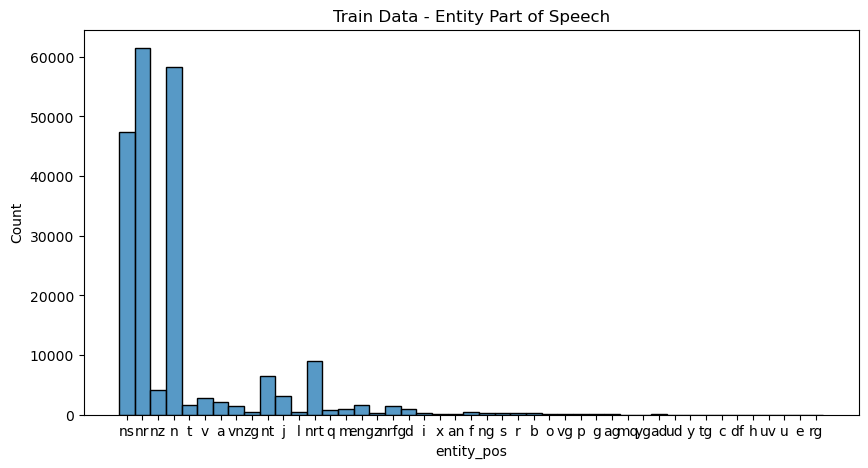

In [998]:
plt.figure(figsize=(10, 5))
dplot = sns.histplot(df2_train['entity_pos'])
dplot.set(title = "Train Data - Entity Part of Speech")
fig = dplot.get_figure()
fig.savefig("Figures/entity_pos_train.png")

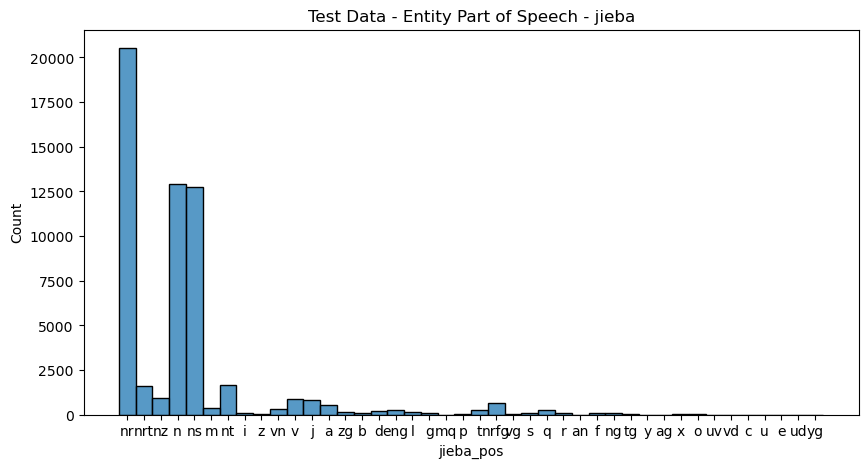

In [1043]:
plt.figure(figsize=(10, 5))
dplot = sns.histplot(df2_test['jieba_pos'])
dplot.set(title = "Test Data - Entity Part of Speech - jieba")
fig = dplot.get_figure()
fig.savefig("Figures/entity_pos_test_jieba.png")


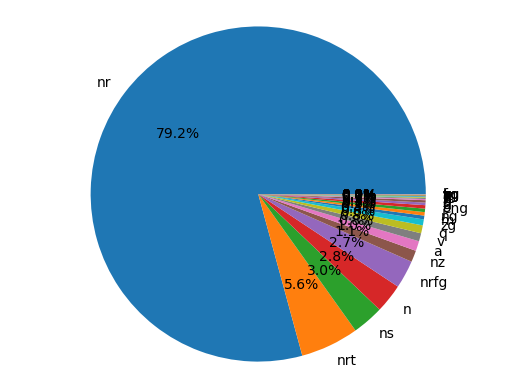

<Figure size 640x480 with 0 Axes>

In [1157]:
#比对LAC与jieba结果
dt=df2_test[df2_test['lac_pos']=='PER']['jieba_pos']
dt_count=dt.value_counts()  
dt_dict=dt_count.to_dict()
# Pie Plot
plt.pie(dt_dict.values(),labels=dt_dict.keys(),autopct='%1.1f%%')
plt.axis('equal')
plt.show()
plt.savefig("Figures/lac_per_pct.png")

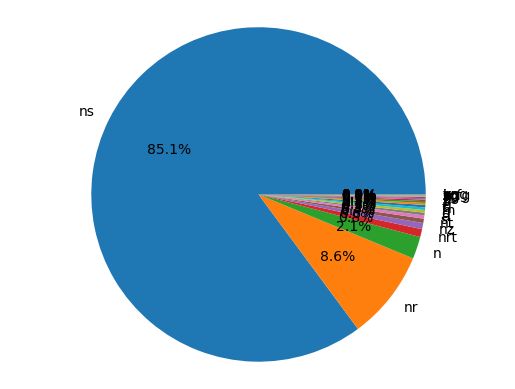

In [1083]:
dt=df2_test[df2_test['lac_pos']=='LOC']['jieba_pos']
dt_count=dt.value_counts()  
dt_dict=dt_count.to_dict()
# Pie Plot
plt.pie(dt_dict.values(),labels=dt_dict.keys(),autopct='%1.1f%%')
plt.axis('equal')
plt.savefig("Figures/lac_loc_pct.png")
plt.show()

In [866]:
#计算每个实体在文本中出现的次数
def count_str(series):
    entity = series["entity"]
    content = series["content"]
    entity_count = content.count(entity)
    return entity_count
df2_train["entity_in_context"] = df2_train.apply(count_str,axis=1)
df2_test["entity_in_context"] = df2_test.apply(count_str,axis=1)

In [877]:
#计算每个entity出现在所有行中的次数
df2_train['entity_in_all'] = df2_train['entity'].map(df2_train['entity'].value_counts())
df2_test['entity_in_all'] = df2_test['entity'].map(df2_test['entity'].value_counts())
#from scipy import stats
#stats.spearmanr(df2_train['entity_in_all'],df2_train['label']) #线性无关
#SpearmanrResult(correlation=-0.03964357623358387, pvalue=1.5584774168443947e-72)

In [895]:
#计算entity出现在文本中的次数/出现在所有文本中的次数
def entity_tfidf(series):
    tf = series["entity_in_context"]
    df = series["entity_in_all"]
    tfidf = tf/df
    return tfidf
df2_train["entity_tfidf"] = df2_train.apply(entity_tfidf,axis=1)
df2_test["entity_tfidf"] = df2_test.apply(entity_tfidf,axis=1)
#stats.spearmanr(df2_train['entity_tfidf'],df2_train['label']) 
#SpearmanrResult(correlation=0.02676518977652347, pvalue=5.178590549621522e-34)

In [869]:
print(df2_train[df2_train['entity_in_context']==0])


           id                                            content  entity  \
55263   23939  在复出的第5场球，克莱.汤普森本赛季终于首次拿下了20+的数据，与活塞的比赛，克莱.汤普森全...   克莱汤普森   
87436   37831  笔者评价：vz.33坦克作为捷克斯洛伐克独立设计出来的一款有代表性的坦克，因为过度追求轻便和...  vz33坦克   
124124  53720  生产历史：主要武器是两门7.92毫米的机枪，动力是由一台4 缸水冷 Praga发动机提供，板...  vz33坦克   

        label  len_content                                              words  \
55263       1          419  [复出, 场球, 克莱, 汤普森, 本赛季, 终于, 首次, 拿下, 20, 数据, 活塞,...   
87436      -1           72  [笔者, 评价, vz, 33, 坦克, 捷克斯洛伐克, 独立, 设计, 一款, 代表性, ...   
124124     -1          484  [生产, 历史, 主要, 武器, 两门, 92, 毫米, 机枪, 动力, 一台, 缸, 水冷...   

        entity_count  entity_in_context  
55263              0                  0  
87436              0                  0  
124124             0                  0  


In [880]:
from scipy import stats
stats.spearmanr(df2_train['entity_in_context'],df2_train['label']) #线性无关

SpearmanrResult(correlation=-0.037851867845707605, pvalue=2.76361344997199e-66)

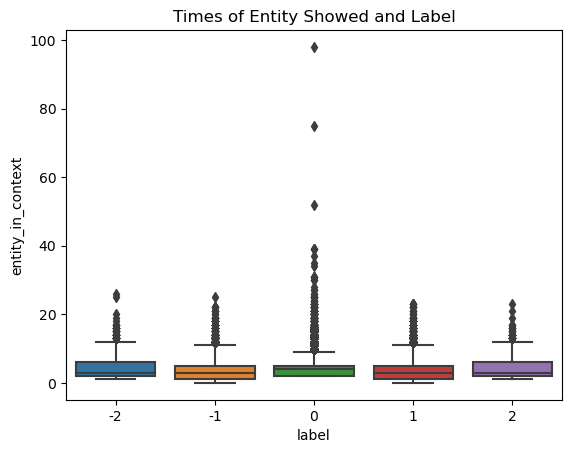

In [937]:
plot = sns.boxplot(x=df2_train['label'],y=df2_train['entity_in_context'],)
plot.set(title = "Times of Entity Showed and Label")
fig = plot.get_figure()
fig.savefig("Figures/EntityCount_Sentiment.png")

### 按实体所在的句子拆分文本

In [1448]:
'''
def split_word(sentence_list, word_list, max_len):
    sentence_str = ''.join(sentence_list)
    word_index_dict = dict((word, sentence_str.find(word)) for word in word_list)
    start = 0
    result = []
    while start < len(sentence_str):
        stop = start + max_len
        need_modify = False
        for word, index in word_index_dict.items():
            if index < stop < index + len(word):
                need_modify = True
                break
        if need_modify:
            stop = index
            word_index_dict[word] = sentence_str.find(word, index + 1)
        result.append(sentence_str[start: stop])
        start = stop
    return result
lst=['这是一个P测试切分函数的句子','这又是gr4532e23一个测试用的句子']
word=['函数','测试']
'''

In [284]:
df = pd.read_json("Data/nlp_data/temp_generated_train.json")
df_train = df[['id','content','entity','label']]
df1 = pd.read_json("Data/nlp_data/temp_generated_test.json")
df_test = df1[['id','content','entity']]


In [282]:
#去掉重复的句子，切分实体所在的句子
import re
def split_entity(series):
    splited = re.split(r"([.。!！?？；;])", series['content'])
    splited.append("") #考虑句尾没有任何标点的情况
    splited = ["".join(i) for i in zip(splited[0::2],splited[1::2])] #把分隔符接到句子后面
    splited = list(set(splited)) #去重
    lst = []
    for s in splited: # 判断字符串中是否存在关键词
        if series['entity'] in s:
            lst.append(s)
        else:
            pass
    result = ''.join(lst) 
    return result


In [283]:
#速度测试
import time
#from pandarallel import pandarallel
#pandarallel.initialize() #并行初始化
dt = df_train.head()
start = time.time()   
dt['content_split'] = dt.apply(split_entity,axis=1) #parallel_apply
end  = time.time()
print('每条处理时间：',(end-start)/5)

每条处理时间： 0.0011214256286621095


/var/folders/s8/sh2pw2j53j93yx3bxdd8zld00000gn/T/ipykernel_5615/3256453440.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['content_split'] = dt.apply(split_entity,axis=1) #parallel_apply


In [285]:
print(dt['content_split'][1])


新疆棉是全球业界公认的高品质天然纤维原料，较好满足了全球范围内对棉制纺织品服装的刚性消费需求，是中国乃至全球纺织工业健康可持续发展的重要原料保障。2021年1月，新疆纺织行业协会发布了详实、客观的《新疆棉纺织行业社会责任报告》，报告以详实的数据和资料充分说明中国新疆维吾尔自治区不存在所谓的“强迫劳动”。


In [286]:
df_train['content_split'] = df_train.apply(split_entity,axis=1) 
df_test['content_split'] = df_test.apply(split_entity,axis=1) 


/var/folders/s8/sh2pw2j53j93yx3bxdd8zld00000gn/T/ipykernel_5615/1275493031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['content_split'] = df_train.apply(split_entity,axis=1)
/var/folders/s8/sh2pw2j53j93yx3bxdd8zld00000gn/T/ipykernel_5615/1275493031.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['content_split'] = df_test.apply(split_entity,axis=1)


In [287]:
del df_train['content']
del df_test['content']
df_train.rename(columns = {'content_split':'content'},inplace=True)
df_test.rename(columns = {'content_split':'content'},inplace=True)


In [288]:
df_train['len_content'] = df_train['content'].apply(lambda x: len(x)) 
df_test['len_content'] = df_test['content'].apply(lambda x: len(x))

/var/folders/s8/sh2pw2j53j93yx3bxdd8zld00000gn/T/ipykernel_5615/2063981721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['len_content'] = df_train['content'].apply(lambda x: len(x))
/var/folders/s8/sh2pw2j53j93yx3bxdd8zld00000gn/T/ipykernel_5615/2063981721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['len_content'] = df_test['content'].apply(lambda x: len(x))


In [279]:
#存在重复字段
rep=df_test[df_test['len_content']>800]['content'].iloc[4]
rep

'张小斐，年轻轻轻，最佳女明星。2021年12月30日晚上，第三十四届中国金鸡百花奖上，张小斐凭借贾玲作品《你好，李焕英》中的扮演主角李焕英荣登红毯。毫无疑问，张小斐是幸运的，因为凭借她的年龄、她的经历、她的作品都不占优势，可是却能出人意料的站在舞台上成为一姐，究竟原因，还是依靠贾玲的影响力以及打造，所以说，张小斐是走了捷径呢还是名副其实呢？张小斐，年轻轻轻，最佳女明星。2021年12月30日晚上，第三十四届中国金鸡百花奖上，张小斐凭借贾玲作品《你好，李焕英》中的扮演主角李焕英荣登红毯。毫无疑问，张小斐是幸运的，因为凭借她的年龄、她的经历、她的作品都不占优势，可是却能出人意料的站在舞台上成为一姐，究竟原因，还是依靠贾玲的影响力以及打造，所以说，张小斐是走了捷径呢还是名副其实呢？张小斐，年轻轻轻，最佳女明星。2021年12月30日晚上，第三十四届中国金鸡百花奖上，张小斐凭借贾玲作品《你好，李焕英》中的扮演主角李焕英荣登红毯。毫无疑问，张小斐是幸运的，因为凭借她的年龄、她的经历、她的作品都不占优势，可是却能出人意料的站在舞台上成为一姐，究竟原因，还是依靠贾玲的影响力以及打造，所以说，张小斐是走了捷径呢还是名副其实呢？张小斐，年轻轻轻，最佳女明星。2021年12月30日晚上，第三十四届中国金鸡百花奖上，张小斐凭借贾玲作品《你好，李焕英》中的扮演主角李焕英荣登红毯。毫无疑问，张小斐是幸运的，因为凭借她的年龄、她的经历、她的作品都不占优势，可是却能出人意料的站在舞台上成为一姐，究竟原因，还是依靠贾玲的影响力以及打造，所以说，张小斐是走了捷径呢还是名副其实呢？张小斐，年轻轻轻，最佳女明星。2021年12月30日晚上，第三十四届中国金鸡百花奖上，张小斐凭借贾玲作品《你好，李焕英》中的扮演主角李焕英荣登红毯。毫无疑问，张小斐是幸运的，因为凭借她的年龄、她的经历、她的作品都不占优势，可是却能出人意料的站在舞台上成为一姐，究竟原因，还是依靠贾玲的影响力以及打造，所以说，张小斐是走了捷径呢还是名副其实呢？张小斐，年轻轻轻，最佳女明星。2021年12月30日晚上，第三十四届中国金鸡百花奖上，张小斐凭借贾玲作品《你好，李焕英》中的扮演主角李焕英荣登红毯。毫无疑问，张小斐是幸运的，因为凭借她的年龄、她的经历、她的作品都不占优势，可是却能出人意料的站在舞台上成为一姐，究竟原因，还是依靠贾玲的影响

In [281]:
splited = re.split(r"([.。!！?？；;])", rep)
splited.append("") #考虑句尾没有任何标点的情况
splited = ["".join(i) for i in zip(splited[0::2],splited[1::2])] #把t分隔符接到句子后面
lst = list(set(splited))
result = ''.join(lst) 
result

'2021年12月30日晚上，第三十四届中国金鸡百花奖上，张小斐凭借贾玲作品《你好，李焕英》中的扮演主角李焕英荣登红毯。张小斐，年轻轻轻，最佳女明星。毫无疑问，张小斐是幸运的，因为凭借她的年龄、她的经历、她的作品都不占优势，可是却能出人意料的站在舞台上成为一姐，究竟原因，还是依靠贾玲的影响力以及打造，所以说，张小斐是走了捷径呢还是名副其实呢？'

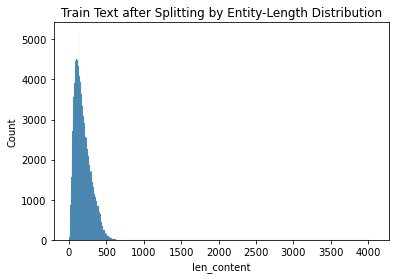

In [294]:
dplot = sns.histplot(df_train['len_content'])
dplot.set(title = "Train Text after Splitting by Entity-Length Distribution")
fig = dplot.get_figure()
fig.savefig("Figures/train_len_split.png")


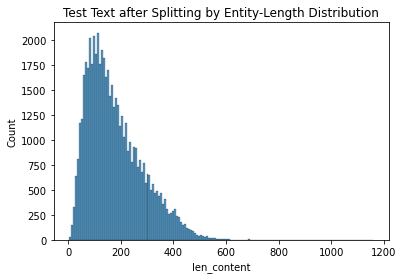

In [295]:
dplot = sns.histplot(df_test['len_content'])
dplot.set(title = "Test Text after Splitting by Entity-Length Distribution")
fig = dplot.get_figure()
fig.savefig("Figures/test_len_split.png")


In [290]:
print('训练数据统计：')
print(df_train['len_content'].describe())
print('测试数据统计：')
print(df_test['len_content'].describe())

训练数据统计：
count    206281.000000
mean        184.823876
std         108.517719
min           0.000000
25%         101.000000
50%         162.000000
75%         250.000000
max        4066.000000
Name: len_content, dtype: float64
测试数据统计：
count    55949.000000
mean       178.077142
std        105.804555
min          3.000000
25%         96.000000
50%        154.000000
75%        241.000000
max       1160.000000
Name: len_content, dtype: float64


In [292]:
print('训练集文本长于512字的样本量：',len(df_train[df_train['len_content']>512]['content']))
print('测试集文本长于512字的样本量：',len(df_test[df_test['len_content']>512]['content']))


训练集文本长于512字的样本量： 1127
测试集文本长于512字的样本量： 235


In [293]:
df_train['len_content'].quantile([0.5,0.8,0.9,0.99])

0.50    162.0
0.80    275.0
0.90    342.0
0.99    482.0
Name: len_content, dtype: float64

In [307]:
train_long = df_train[df_train['len_content']>512][['content','entity','label']]
train_long.to_csv("train_long.csv",index=False)

In [309]:
df_train[df_train['len_content']>512]['label'].value_counts(normalize=True,sort=True)

 0    0.592724
 1    0.226264
-1    0.122449
-2    0.036380
 2    0.022183
Name: label, dtype: float64

In [297]:
#训练集里的空文本情况：目标实体与文本符号不匹配
df_train[df_train['len_content']==0][['id','entity']]

,id,entity
55263,23939,克莱汤普森
87436,37831,vz33坦克
124124,53720,vz33坦克


In [304]:
df_test[df_test['id']==5020184][['id','entity','content']]

,id,entity,content
42144,5020184,伍珂玥,伍珂玥
42145,5020184,深圳,2019年2月6日，参加中央广播电视总台春节联欢晚会深圳分会场，与汪明荃、阿瑞、姚璎格等艺人...
42146,5020184,歌曲,2019年2月6日，参加中央广播电视总台春节联欢晚会深圳分会场，与汪明荃、阿瑞、姚璎格等艺人...


In [144]:
train_long[train_long['label']==-2]['content'].iloc[0]


'在儿子朱小伟离婚之后，大衣嫂竟然是罕见的发飙了，好像这是从大衣哥出名之后第一次见大衣嫂发飙，大衣嫂一直是以微笑示人，每次见到她都是乐乐呵呵，性格特别好，人看着就非常善良。那么大衣嫂这次是因为什么发飙呢，这就要说到儿子儿媳的离婚事件了。儿子朱小伟已经和儿媳陈亚男彻底的断了，这件事情也是闹了很长时间，大衣嫂的生活也受到了困扰，可是大衣嫂和大衣哥一样，一直没有出来发声，一问就说让两个年轻人自己处理。不过就在朱小伟刚刚离婚之后，大衣嫂竟然拍视频，对着手机向一个人喊话，那就是大衣哥的经纪人深秋。原来是大衣嫂在怒骂经纪人深秋，大衣嫂说，深秋不是他们村的人，更不是她的表妹和亲妹妹，她只是邻村的人，到他们村租了一个房子住，而且平时跟她也不熟，大衣哥的很多事大家也不要再联系她，甚至还说深秋这次在儿子儿媳的婚姻事件中从中使坏。更是对深秋喊话如果再胡说就撕烂你的嘴，所以看来大衣嫂真的是非常生气了，从来没见大衣嫂这么愤怒过，这次深秋确实是把大衣嫂给惹急了，如果深秋没做过这些事，大衣嫂也不会这么说，所以看来大衣嫂也是侧面的证实了深秋确实是做了坏事。可能在大衣嫂的心里也是认为我儿能够离婚都怨你，如果不是你从中掺和，可能还不会这样呢。大衣嫂说的话跟陈亚男小姨当初骂深秋是一样的话，所以看来这次婚姻事件中，深秋真的是脱不了干系了。'

In [148]:
train_long[train_long['label']==0]['content']

526       要长治久安，全港市民应当更全面认识“一国两制”、更忠诚维护国家安全，以国家发展为荣，以中国人...
527       10月6日，香港特区行政长官林郑月娥在立法会宣读2021年施政报告，这是她发表的任内第五份施...
692       高中毕业之后，我就去工作了，刚开始的时候，我是在一家服装店工作，我很喜欢服装店的工作环境，每...
1218      虽然是一名犹太人，然而他在讲课的时候全程使用中文交流，甚至其口中满是东北特色语言，犹太人是特...
1251      大周末，中东地区突然发生了一场极为重大的事件，伊拉克总理府突然遭到极为严重的袭击，虽然人并没...
                                ...                        
205255    刘和平：这场和美国北约的较量 直新闻：刘先生，美国和北约分别以书面形式回复俄罗斯的安全保证要...
205494    要始终保持政治上的清醒坚定，坚决当好“两个确立”的坚定捍卫者、忠实践行者，坚决当好习近平新时...
206024    北京时间7月30日，2020东京奥运会赛艇女子八人单桨有舵手A组决赛在海之森水上竞技场正式开...
206025    北京时间7月30日，2020东京奥运会赛艇女子八人单桨有舵手A组决赛在海之森水上竞技场正式开...
206147    生肖猴属猴的人擅长与人打交道，而更擅长在生活中寻找进步的门路，他们不会停留在原地，也不会让生...
Name: content, Length: 564, dtype: object

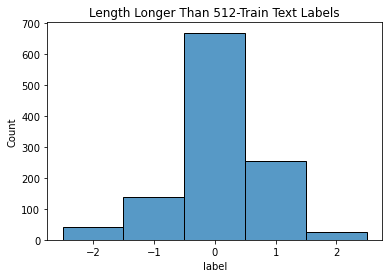

In [310]:
plot = sns.histplot(df_train[df_train['len_content']>512]['label'],discrete=True)
plot.set(title = "Length Longer Than 512-Train Text Labels")
fig3 = plot.get_figure()
fig3.savefig("Figures/train_label_g512.png")


In [86]:
'''
demo = df_train[:1000]
train=demo[['id','content','entity','label']]
train_d=train.to_dict('records')
'''

In [65]:
'''
demo1 = df_test[:1000]
test=demo1[['id','content','entity']]
test_d=test.to_dict('records')
'''

In [50]:
#For json,convert single quote to double quote
#import json
#b = str(train_d).replace("'","\"").replace(r"\n","")
#b = json.dumps(train_d,ensure_ascii=False)


In [311]:
train=df_train[['id','content','entity','label']]
train_d=train.to_dict('records') #转成dict
test=df_test[['id','content','entity']]
test_d=test.to_dict('records')

In [312]:
def write_txt(filepath,lstname):
    with open(filepath,'w',encoding='utf-8') as fw:
        for i in range(len(lstname)):
            #lstname[i] = str(lstname[i]).replace("'","\"") #.replace(r"\n","")
            fw.write(json.dumps(lstname[i], ensure_ascii=False)+ "\n")
            #print(lstname[i], file=fw)
        fw.close()
write_txt('Data/nlp_data/content_split_train.txt',train_d)
write_txt('Data/nlp_data/content_split_test.txt',test_d)


In [ ]:
'''
with open(os.path.join(input_file,"train.txt"), 'r', encoding='utf-8') as f:
    lines = f.readlines()
    with open(os.path.join(output_file,"generated_train_data.txt"), 'w',encoding='utf-8') as fw:
        for line in lines:
            taskData = json.loads(line.strip())
            contents = taskData['content']
            entitys = taskData['entity']
            id = taskData["id"]
            for entity, label in entitys.items():
                data = new_data_piece(id, content=contents,
                                      entity=entity, label=int(label),is_train=True)
                fw.write(json.dumps(data, ensure_ascii=False) + "\n")
'''

### 滑动窗口文本构建

In [423]:
def entity_window(series):
    splited = re.split(r"([，,.。!！?？；;])",series['content']) #按分句切割
    splited.append("") 
    line_split = ["".join(i) for i in zip(splited[0::2],splited[1::2])] 
    entity = series['entity']
    contain_indexs=[index for index,sent in enumerate(line_split) if entity in sent] 
    tmp=[] 
    for index in contain_indexs:
        if index==0:
            tmp.extend(line_split[index:index+2]) #看自身到下一句
        elif index==1:
            tmp.extend(line_split[index-1:index+2]) #看前一句到下一句
        elif index==len(line_split)-1:
            tmp.extend(line_split[index-2:]) #看自身和前一句
        else:
            tmp.extend(line_split[index-1:index+2]) #看前一句到下一句
        tmp=sorted(set(tmp), key=tmp.index)
    result=''.join(tmp)
    return result

In [444]:
def ew(text):
    splited = re.split(r"([，,.。!！?？；;])",text) #按分句切割
    splited.append("") 
    line_split = ["".join(i) for i in zip(splited[0::2],splited[1::2])] 
    contain_indexs=[index for index,sent in enumerate(line_split) if entity in sent] 
    tmp=[] 
    for index in contain_indexs:
        if index==0:
            tmp.extend(line_split[index:index+2]) #看自身到下一句
        elif index==1:
            tmp.extend(line_split[index-1:index+2]) #看前一句到下一句
        elif index==len(line_split)-1:
            tmp.extend(line_split[index-2:]) #看自身和前一句
        else:
            tmp.extend(line_split[index-1:index+2]) #看前一句到下一句
        tmp=sorted(set(tmp), key=tmp.index)
    result=''.join(tmp)
    return result

In [445]:
test='在儿子朱小伟离婚之后，大衣嫂竟然是罕见的发飙了，好像这是从大衣哥出名之后第一次见大衣嫂发飙，大衣嫂一直是以微笑示人，每次见到她都是乐乐呵呵，性格特别好，人看着就非常善良。那么大衣嫂这次是因为什么发飙呢，这就要说到儿子儿媳的离婚事件了。儿子朱小伟已经和儿媳陈亚男彻底的断了，这件事情也是闹了很长时间，大衣嫂的生活也受到了困扰，可是大衣嫂和大衣哥一样，一直没有出来发声，一问就说让两个年轻人自己处理。不过就在朱小伟刚刚离婚之后，大衣嫂竟然拍视频，对着手机向一个人喊话，那就是大衣哥的经纪人深秋。原来是大衣嫂在怒骂经纪人深秋，大衣嫂说，深秋不是他们村的人，更不是她的表妹和亲妹妹，她只是邻村的人，到他们村租了一个房子住，而且平时跟她也不熟，大衣哥的很多事大家也不要再联系她，甚至还说深秋这次在儿子儿媳的婚姻事件中从中使坏。更是对深秋喊话如果再胡说就撕烂你的嘴，所以看来大衣嫂真的是非常生气了，从来没见大衣嫂这么愤怒过，这次深秋确实是把大衣嫂给惹急了，如果深秋没做过这些事，大衣嫂也不会这么说，所以看来大衣嫂也是侧面的证实了深秋确实是做了坏事。可能在大衣嫂的心里也是认为我儿能够离婚都怨你，如果不是你从中掺和，可能还不会这样呢。大衣嫂说的话跟陈亚男小姨当初骂深秋是一样的话，所以看来这次婚姻事件中，深秋真的是脱不了干系了。'
entity='大衣嫂'
ew(test)

'在儿子朱小伟离婚之后，大衣嫂竟然是罕见的发飙了，好像这是从大衣哥出名之后第一次见大衣嫂发飙，大衣嫂一直是以微笑示人，每次见到她都是乐乐呵呵，人看着就非常善良。那么大衣嫂这次是因为什么发飙呢，这就要说到儿子儿媳的离婚事件了。这件事情也是闹了很长时间，大衣嫂的生活也受到了困扰，可是大衣嫂和大衣哥一样，一直没有出来发声，不过就在朱小伟刚刚离婚之后，大衣嫂竟然拍视频，对着手机向一个人喊话，那就是大衣哥的经纪人深秋。原来是大衣嫂在怒骂经纪人深秋，大衣嫂说，深秋不是他们村的人，更是对深秋喊话如果再胡说就撕烂你的嘴，所以看来大衣嫂真的是非常生气了，从来没见大衣嫂这么愤怒过，这次深秋确实是把大衣嫂给惹急了，如果深秋没做过这些事，大衣嫂也不会这么说，所以看来大衣嫂也是侧面的证实了深秋确实是做了坏事。可能在大衣嫂的心里也是认为我儿能够离婚都怨你，如果不是你从中掺和，可能还不会这样呢。大衣嫂说的话跟陈亚男小姨当初骂深秋是一样的话，所以看来这次婚姻事件中，'

In [447]:
len(test)

557

In [446]:
len(ew(test))

422

In [428]:
train_w = df_train.copy(deep=True)
test_w = df_test.copy(deep=True)

In [430]:
train_w['content_w']=train_w.apply(entity_window,axis=1) 
test_w['content_w']=test_w.apply(entity_window,axis=1) 

In [ ]:
###

In [474]:
df_train1 = text_to_df('Data/nlp_data/train.txt')
df_test1 = text_to_df('Data/nlp_data/test.txt')

In [479]:
df2_train['len_content'] = df2_train['content'].apply(lambda x: len(x)) 
df2_test['len_content'] = df2_test['content'].apply(lambda x: len(x)) 

In [480]:
print('训练集文本长于512字的样本量：',len(df2_train[df2_train['len_content']>512]['content']))
print('测试集文本长于512字的样本量：',len(df2_test[df2_test['len_content']>512]['content']))

训练集文本长于512字的样本量： 25671
测试集文本长于512字的样本量： 5869


In [481]:
print('训练集：\n',df2_train['len_content'].describe())
print('测试集：\n',df2_test['len_content'].describe())

训练集：
 count    206281.000000
mean        417.237521
std         116.820562
min           8.000000
25%         402.000000
50%         431.000000
75%         474.000000
max        4960.000000
Name: len_content, dtype: float64
测试集：
 count    55949.000000
mean       395.995210
std        128.269083
min         12.000000
25%        357.000000
50%        425.000000
75%        466.000000
max       2517.000000
Name: len_content, dtype: float64


In [ ]:
###

In [434]:
train_w['len_window'] = train_w['content_w'].apply(lambda x: len(x)) 
test_w['len_window'] = test_w['content_w'].apply(lambda x: len(x)) 

In [443]:
print('训练集：\n',train_w['len_window'].describe())
print('测试集：\n',test_w['len_window'].describe())

训练集：
 count    206281.000000
mean        142.160257
std          87.919738
min           0.000000
25%          76.000000
50%         121.000000
75%         190.000000
max        3318.000000
Name: len_window, dtype: float64
测试集：
 count    55949.000000
mean       138.756493
std         86.480560
min          3.000000
25%         73.000000
50%        117.000000
75%        186.000000
max       1160.000000
Name: len_window, dtype: float64


In [2]:
print('训练集文本长于512字的样本量：',len(train_w[train_w['len_window']>512]['content_w']))
print('测试集文本长于512字的样本量：',len(test_w[test_w['len_window']>512]['content_w']))

NameError: name 'train_w' is not defined

In [452]:
test_w.head()

,id,entity,content,len_content,content_w,len_window
0,5000001,施廷懋,然而作为同龄的选手，王涵也不想把所有的压力都压在施廷懋一人的肩上，“当然我也可以给予她一些帮...,109,然而作为同龄的选手，王涵也不想把所有的压力都压在施廷懋一人的肩上，“当然我也可以给予她一些帮...,78
1,5000001,王涵,然而作为同龄的选手，王涵也不想把所有的压力都压在施廷懋一人的肩上，“当然我也可以给予她一些帮...,123,然而作为同龄的选手，王涵也不想把所有的压力都压在施廷懋一人的肩上，“当然我也可以给予她一些帮...,81
2,5000002,阿尔弗雷德·诺贝尔,1968年，瑞典央行设立“瑞典中央银行纪念阿尔弗雷德·诺贝尔经济学奖”，即俗称的诺贝尔经济学...,236,1968年，瑞典央行设立“瑞典中央银行纪念阿尔弗雷德·诺贝尔经济学奖”，即俗称的诺贝尔经济学...,148
3,5000002,诺贝尔奖委员会,◆诺贝尔奖是如何评选的据诺贝尔奖委员会官网介绍，诺贝尔奖由瑞典发明家、企业家阿尔弗雷德·诺贝...,124,◆诺贝尔奖是如何评选的据诺贝尔奖委员会官网介绍，诺贝尔奖由瑞典发明家、企业家阿尔弗雷德·诺贝...,113
4,5000003,威少,上半场比赛中威少这边的进攻状态依旧不是太好，只不过对比威少以往的表现，这场比赛威少的进攻也算...,101,上半场比赛中威少这边的进攻状态依旧不是太好，只不过对比威少以往的表现，这场比赛威少的进攻也算...,101


In [458]:
train_w.drop(columns=['content','len_content','len_window'],inplace=True)  
test_w.drop(columns=['content','len_content','len_window'],inplace=True)  
train_w.rename(columns = {'content_w':'content'},inplace=True)
test_w.rename(columns = {'content_w':'content'},inplace=True)

In [460]:
train_w.head()

,id,entity,label,content
0,1,美国,0,约占全球棉花产量的20%，美国政府打压新疆棉花及其制品的行为，势必严重危害全球纺织产业供应链...
1,1,中国,0,新疆纺织行业协会发布了详实、客观的《新疆棉纺织行业社会责任报告》，报告以详实的数据和资料充分...
2,2,德约,-1,去年美网，梅德韦杰夫在决赛中以3比0完胜志在冲击年度全满贯神迹的德约，为男子网坛90后选手从...
3,2,梅德韦杰夫,1,去年美网，梅德韦杰夫在决赛中以3比0完胜志在冲击年度全满贯神迹的德约，为男子网坛90后选手从...
4,2,澳网,0,今年，梅德韦杰夫作为澳网男单最大热门，完全有实力为90后选手实现澳网冠军零的突破，从目前的形...


### 储存Dataframe到txt

In [ ]:
#dataframe to dictionary
train_w=train_w[['id','content','entity','label']]
train_wd=train_w.to_dict('records') 
test_w=test_w[['id','content','entity']]
test_wd=test_w.to_dict('records')

In [ ]:
def write_txt(filepath,lstname):
    with open(filepath,'w',encoding='utf-8') as fw:
        for i in range(len(lstname)):
            fw.write(json.dumps(lstname[i], ensure_ascii=False)+ "\n")
        fw.close()
write_txt('Data/nlp_data/content_window_train.txt',train_wd)
write_txt('Data/nlp_data/content_window_test.txt',test_wd)


### 数据分布

In [732]:
print('训练数据统计：')
print(df_train[['len_content','entity_num']].describe())
print('测试数据统计：')
print(df_test[['len_content','entity_num']].describe())

训练数据统计：
        len_content    entity_num
count  89195.000000  89195.000000
mean     404.117406      2.312697
std      125.100228      1.327276
min        8.000000      1.000000
25%      394.000000      2.000000
50%      426.000000      2.000000
75%      467.000000      3.000000
max     4960.000000     19.000000
测试数据统计：
        len_content    entity_num
count  26766.000000  26766.000000
mean     381.546514      2.090301
std      138.928884      1.110161
min       12.000000      1.000000
25%      306.000000      1.000000
50%      420.000000      2.000000
75%      461.000000      2.000000
max     2517.000000     15.000000


In [841]:
len(df2_train[df2_train['label']==1])

30367

同时出现一系列人名时，情感极性可能相同，代表组织、职业、地点一类的实体可能极性不同

In [734]:
print(df_train[df_train['entity_num']==19])

          id                                            content  \
68480  68481  新京报快讯 据全国妇联女性之声官微消息，在第32届奥林匹克运动会上，我国体育健儿大力弘扬奥林...   
77742  77743  25日中国国家话剧院迎来创建80周年、正式成立20周年纪念日。为感谢院外艺术家对剧院多年来艺...   

                                                  entity  len_content  \
68480  {'杨倩': 1, '侯志慧': 1, '孙一文': 1, '姜冉馨': 1, '张灵': ...          447   
77742  {'雷恪生': 1, '胡歌': 1, '明哲': 1, '王晓鹰': 1, '许文广': ...          258   

                                                   words  entity_num  
68480  [新, 京报, 快讯, 全国妇联, 女性, 之声, 官微, 消息, 32, 届, 奥林匹克运...          19  
77742  [25, 日, 中国, 国家, 话剧院, 迎来, 创建, 80, 周年, 正式, 成立, 2...          19  


In [740]:
df_train.loc[68480,'content']

'25日中国国家话剧院迎来创建80周年、正式成立20周年纪念日。为感谢院外艺术家对剧院多年来艺术创作的支持，剧院授予奚美娟、胡歌、黄磊三人“荣誉演员”称号，并已将证书寄给本人。同时，剧院还引进了演员万茜、张桐、关晓彤等，舞美设计王琛、胡天骥等25名高端人才。院长田沁鑫现场宣布，授予张奇虹、游本昌、雷恪生、薛殿杰、唐国强、李雪健六人中国国家话剧院“终身荣耀艺术家”称号。退而不休、为中国国家话剧院继续作出贡献的“荣耀艺术家”获得者则包括了马迎春、陈强、查明哲、韩童生、王晓鹰、杨青、刘威、刘佩琦、倪大红、许文广等十人。'

In [742]:
df_train.loc[68480,'entity']

{'杨倩': 1,
 '侯志慧': 1,
 '孙一文': 1,
 '姜冉馨': 1,
 '张灵': 1,
 '吕扬': 1,
 '崔晓桐': 1,
 '张雨霏': 1,
 '杨浚瑄': 1,
 '朱雪莹': 1,
 '卢云秀': 1,
 '巩立姣': 1,
 '汪周雨': 1,
 '鲍珊菊': 1,
 '刘诗颖': 1,
 '徐诗晓': 1,
 '孙梦雅': 1,
 '运动员': 0,
 '全国妇联': 0}

#### 训练数据

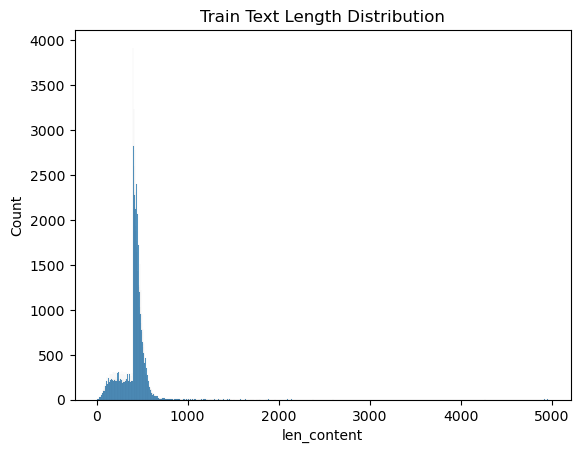

In [486]:
dplot = sns.histplot(df_train['len_content'])
dplot.set(title = "Train Text Length Distribution")
fig = dplot.get_figure()
fig.savefig("train_len.png")

In [760]:
a = df_train.loc[:,'len_content'].value_counts() #统计len_content这一列每个元素出现的个数
b = a.idxmax()  # 找出最多的文本长度
print(a)

405     987
401     985
400     984
402     983
403     969
       ... 
895       1
839       1
825       1
1170      1
1028      1
Name: len_content, Length: 933, dtype: int64


In [326]:
print('训练数据文本最长长度：', max(df_train['len_content']))
print('训练数据文本最短长度：', min(df_train['len_content']))
print('训练数据文本出现最多次的长度：', b)

训练数据文本最长长度： 4960
训练数据文本最短长度： 8
训练数据文本出现最多次的长度： 405


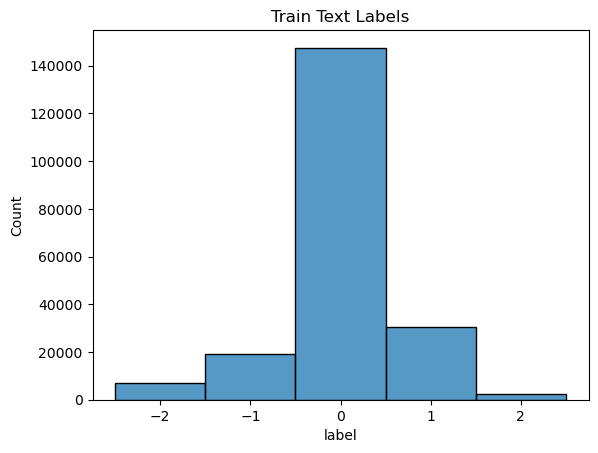

In [771]:
plot = sns.histplot(df2_train['label'],discrete=True)
plot.set(title = "Train Text Labels")
fig3 = plot.get_figure()
fig3.savefig("Figures/train_label.png")

In [774]:
df2_train['label'].value_counts(normalize=True,sort=True)

 0    0.715359
 1    0.147212
-1    0.092495
-2    0.033842
 2    0.011092
Name: label, dtype: float64

#### 1.出现次数最多的实体极性分析   
选前10出现最多的entity

In [414]:
count_csv = df2_train['entity'].value_counts()  
print(count_csv)
count_csv.to_csv("count.csv",mode='a')

中国       4306
美国       3410
球队       1467
球员       1421
病例       1330
         ... 
三江源         1
生肖兔         1
张云涛         1
AC米兰队       1
南雄          1
Name: entity, Length: 29991, dtype: int64


In [445]:
#训练集出现次数最多的entity
entity_train = count_csv.index.tolist()
print(entity_train_lst[:10])

['中国', '美国', '球队', '球员', '病例', '日本', '北京', '俄罗斯', '湖人', '詹姆斯']


In [459]:
'''
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei') 
'''

In [476]:
def save_his(lst, num_ent):
    for i in range(num_ent):
        result = lst[i]
        x = df2_train[df2_train['entity']==result].label #绘制数据集
        plot = sns.histplot(x,discrete=True)
        plot.set(title = "Top Entity")
        plot.set_xticks(ticks=[-2,-1,0,1,2])
        fig = plot.get_figure()
        fig.savefig("Figures/temp{}.png".format(result))
        fig.clf()

save_his(entity_train,10)
save_his(['粉丝','台湾'], 2)

<Figure size 432x288 with 0 Axes>

#### 2.最正面和最负面的实体
按正面和负面分别可视化词云

In [637]:
df_pos = df2_train[(df2_train['label']==1)| (df2_train['label']==2)]
df_neg = df2_train[(df2_train['label']==-1)| (df2_train['label']==-2)]

In [844]:
print('正样本个数：',len(df_pos))
print('负样本个数：',len(df_neg))
print('正负样本比：',len(df_pos)/len(df_neg))

正样本个数： 32655
负样本个数： 26061
正负样本比： 1.2530217566478645


In [647]:
pos_ent_lst = df_pos['entity'].tolist()
neg_ent_lst = df_neg['entity'].tolist()

In [648]:
#统计实体频次
pos_freq = pd.value_counts(pos_ent_lst).to_dict()
neg_freq = pd.value_counts(neg_ent_lst).to_dict()

In [662]:
from wordcloud import WordCloud, ImageColorGenerator
wcd = WordCloud(font_path="/System/Library/fonts/PingFang.ttc",
               background_color='black')
wcd.generate_from_frequencies(neg_freq)

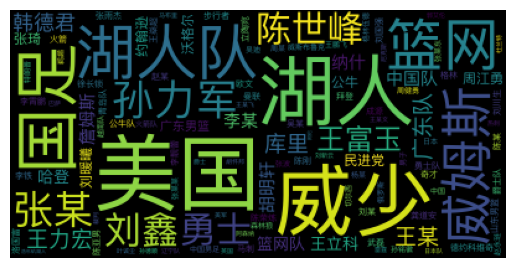

In [663]:
def plt_imshow(x, ax=None, show=True):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(x)
    ax.axis("off")
    if show: plt.show()
    return ax
ax=plt_imshow(wcd)
ax.figure.savefig(f'Figures/neg_wcd.png', bbox_inches='tight', dpi=150)

#### 3.计算文本情感值

In [ ]:
#去掉中性文本
df_no0 = df2_train[(df2_train['label']!=0)]

In [677]:
count_no0 = df_no0['entity'].value_counts()  
print(count_no0)
count_no0.to_csv("no0_count.csv",mode='a')

詹姆斯        546
威少         512
湖人         462
美国         398
篮网         351
          ... 
山歌好比春江水      1
十月围城         1
吴兵           1
阿里亚西姆        1
奇葩说          1
Name: entity, Length: 14021, dtype: int64


In [679]:
lst = count_no0.index.tolist()
print(lst[:10])

['詹姆斯', '威少', '湖人', '美国', '篮网', '库里', '勇士', '哈登', '湖人队', '国足']


In [682]:
def save_his1(lst, num_ent):
    for i in range(num_ent):
        result = lst[i]
        x = df_no0[df_no0['entity']==result].label #绘制数据集
        plot = sns.histplot(x,discrete=True)
        plot.set(title = "Top Entity")
        plot.set_xticks(ticks=[-2,-1,0,1,2])
        fig = plot.get_figure()
        fig.savefig("Figures/no0{}.png".format(result))
        fig.clf()

save_his1(lst,10)

<Figure size 640x480 with 0 Axes>

In [708]:
lst=dt['words'].tolist()

In [709]:
flat_3 = []
for l in lst:
    flat_3.extend(l)

In [711]:
test = pd.value_counts(flat_3).to_dict()

In [712]:
wcd = WordCloud(font_path="/System/Library/fonts/PingFang.ttc",
               background_color='black')
wcd.generate_from_frequencies(test)

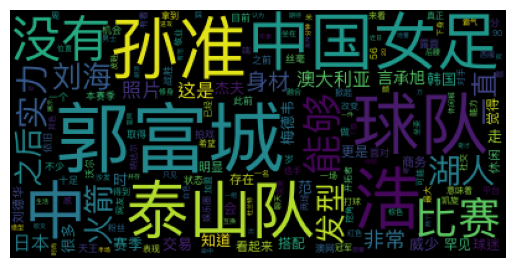

In [714]:
ax=plt_imshow(wcd)
#ax.figure.savefig(f'Figures/neg_wcd.png', bbox_inches='tight', dpi=150)

In [713]:
dt['sentiment'] = dt['content'].apply(lambda x: SnowNLP(x).sentiments) 

/var/folders/s8/sh2pw2j53j93yx3bxdd8zld00000gn/T/ipykernel_6569/1683582782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['sentiment'] = dt['content'].apply(lambda x: SnowNLP(x).sentiments)


In [892]:
SnowNLP('新疆棉是全球业界公认的高品质天然纤维原料，较好满足了全球范围内对棉制纺织品服装的刚性消费').sentiments

0.12885390948471243

In [617]:
df_aggmean = df2_train.groupby('entity')['label'].agg(['sum','mean','count','min', 'max']).reset_index()

In [630]:
df_aggmean.sort_values(by=['sum','mean'])

,entity,sum,mean,count,min,max
22118,美国,-373,-0.109384,3410,-2,2
8997,孙力军,-309,-1.968153,157,-2,-1
27576,陈世峰,-255,-1.976744,129,-2,-1
11924,张某,-246,-1.421965,173,-2,0
19506,王富玉,-223,-1.939130,115,-2,0
...,...,...,...,...,...,...
1329,中国,131,0.030423,4306,-1,2
15532,杜兰特,140,0.406977,344,-2,2
7073,哈登,144,0.274809,524,-2,2
21706,纳达尔,201,0.804000,250,-1,2


In [628]:
df_aggmean.nlargest(30, 'mean')

,entity,sum,mean,count,min,max
43,5G RAN,2,2.0,1,2,2
80,AndyMurray,2,2.0,1,2,2
126,CJ-麦科勒姆,2,2.0,1,2,2
178,Elsa Hosk,2,2.0,1,2,2
416,Zahara,2,2.0,1,2,2
566,七孔桥,2,2.0,1,2,2
724,三生三世枕上书,2,2.0,1,2,2
1490,中国海洋石油国际有限公司,2,2.0,1,2,2
2070,乔德约科维奇,2,2.0,1,2,2
2108,乘风破浪的姐姐们,2,2.0,1,2,2


<class 'pandas.core.frame.DataFrame'>
Int64Index: 58716 entries, 2 to 206280
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           58716 non-null  int64 
 1   content      58716 non-null  object
 2   entity       58716 non-null  object
 3   label        58716 non-null  int64 
 4   len_content  58716 non-null  int64 
 5   words        58716 non-null  object
dtypes: int64(3), object(3)
memory usage: 5.2+ MB


In [576]:
df_neg.sort_values(by='mean')

KeyError: 'mean'

In [687]:
dt=df2_train[0:1000]

In [688]:
dt[(dt['entity']=='中国')]

,id,content,entity,label,len_content,words
1,1,3.新疆棉是全球业界公认的高品质天然纤维原料，较好满足了全球范围内对棉制纺织品服装的刚性消费...,中国,0,481,"[新疆棉, 全球, 业界, 公认, 高品质, 天然纤维, 原料, 满足, 全球, 范围, 棉..."
26,13,网友回答：这个问题很有意思，因为我就曾幻想过娶一位白人女子为妻，可惜我已经老了，我年轻的时候...,中国,0,478,"[网友, 回答, 问题, 有意思, 幻想, 娶, 一位, 白人, 女子, 为妻, 可惜, 已..."
234,104,赛道上的红色闪电——武大靖2018年的韩国平昌奥运会注定是让国人印象深刻的一届冬奥会，在这...,中国,0,241,"[赛道, 红色, 闪电, 武大, 靖, 2018, 年, 韩国, 平昌, 奥运会, 注定, ..."
235,105,全球最应该做的是什么？现在全球最应该做的是，积极地接种新冠疫苗，降低感染发病的可能性，只要能...,中国,0,314,"[全球, 应该, 做, 现在, 全球, 应该, 做, 积极, 接种, 新冠, 疫苗, 降低,..."
250,113,8，有谈判成果吗？基本上各说各话、互不相让。但怎么说呢，会谈没有取得成果，但会谈本身就是成果...,中国,0,302,"[谈判, 成果, 基本上, 各说各话, 互不相让, 说, 会谈, 没有, 取得, 成果, 会..."
278,125,北京冬奥会举办时适逢新春佳节，当白色与红色在调色盘中碰撞，皮影、中国剪纸等蕴含中国传统文化的...,中国,0,446,"[北京, 冬奥会, 举办, 时, 适逢, 新春佳节, 白色, 红色, 调色盘, 中, 碰撞,..."
345,149,攻读硕士研究生期间，她还和导师一起加入当时研究北斗卫星系统的团队，而这，也成为了她之后“犯错...,中国,0,401,"[攻读, 硕士, 研究生, 期间, 导师, 一起, 加入, 当时, 研究, 北斗, 卫星, ..."
437,189,治安提醒：抢劫、枪杀、地铁推人等恶性治安事件频发驻美国使馆1月27日发布节日系列领事提醒，在...,中国,0,519,"[治安, 提醒, 抢劫, 枪杀, 地铁, 推人, 恶性, 治安, 事件, 频发, 驻, 美国..."
439,190,美国对中国在西方的形象开展了积极且成功的“大锤行动”。如果北京胆敢反击这场宣传战，那么，美...,中国,0,107,"[美国, 中国, 西方, 形象, 开展, 积极, 成功, 大锤, 行动, 北京, 胆敢, 反..."
454,194,这些天来，很多人都记住了这几个名字：18岁的“天才少女”谷爱凌、17岁的“单板小将”苏翊鸣、...,中国,0,465,"[天来, 很多, 记住, 几个, 名字, 18, 岁, 天才, 少女, 谷爱凌, 17, 岁..."


In [398]:
dt.groupby('entity').agg({'label':{'max','min','mean'}})

label        
             mean min max
entity                   
0107          0.0   0   0
12306         0.0   0   0
2022年春节联欢晚会   0.0   0   0
35岁           0.0   0   0
8月31日         0.0   0   0
...           ...  ..  ..
黄在群          -1.0  -1  -1
黄晓明           0.0   0   0
黄某           -1.0  -1  -1
黄浦区           0.0   0   0
黑猫            0.0   0   0

[784 rows x 3 columns]

In [397]:
dt[(dt['entity']=='中国')].label.value_counts()

0    21
Name: label, dtype: int64

In [394]:
dt.sort_values(by='label')

,id,content,entity,label,len_content,words
849,374,后来，男子又把女子从沙发上摁倒在贵妃沙发上，继续左右开弓，死命殴打，他们的孩子就站在身后看着...,王某飞,-2,410,"[后来, ，, 男子, 又, 把, 女子, 从, 沙发, 上, 摁, 倒, 在, 贵妃, 沙..."
219,98,上述媒体报道提到，那封署名是“一名爱国的文物爱好者”的举报信提到，宋氏兄弟私藏文物超过洛阳博...,王文海,-2,201,"[上述, 媒体报道, 提到, ，, 那封, 署名, 是, “, 一名, 爱国, 的, 文物,..."
878,385,该负责人说，2021年10月，深圳警方在侦办另一宗拐骗儿童积案时获取重要线索，山东省聊城市阳...,吴某某,-2,434,"[该, 负责人, 说, ，, 2021, 年, 10, 月, ，, 深圳, 警方, 在, 侦..."
220,98,上述媒体报道提到，那封署名是“一名爱国的文物爱好者”的举报信提到，宋氏兄弟私藏文物超过洛阳博...,宋氏四兄弟,-2,201,"[上述, 媒体报道, 提到, ，, 那封, 署名, 是, “, 一名, 爱国, 的, 文物,..."
766,338,“当时并没有负罪感，觉得是他们应该给的”，“我由一开始对自己的错误认识不足，到逐步认识，确实...,刘国强,-2,503,"[“, 当时, 并, 没有, 负罪感, ，, 觉得, 是, 他们, 应该, 给, 的, ”,..."
...,...,...,...,...,...,...
110,49,三档5人，德雷蒙德格林显然被低估了，他的进攻虽然不出色，但是他在组织进攻和防守方面都是其他四...,乐福,2,478,"[三档, 5, 人, ，, 德, 雷蒙德, 格林, 显然, 被, 低估, 了, ，, 他, ..."
641,280,和九寨沟相比，荔波少了一点妩媚，却多了一些素雅。始于清朝时期的「七孔拱桥」，有着近200年的...,七孔桥,2,412,"[和, 九寨沟, 相比, ，, 荔波, 少, 了, 一点, 妩媚, ，, 却, 多, 了, ..."
404,174,俞飞鸿，1971年1月15日出生于浙江省杭州市，中国内地影视女演员、导演，毕业于北京电影学院...,俞飞鸿,2,425,"[俞飞鸿, ，, 1971, 年, 1, 月, 15, 日出, 生于, 浙江省, 杭州市, ..."
106,49,三档5人，德雷蒙德格林显然被低估了，他的进攻虽然不出色，但是他在组织进攻和防守方面都是其他四...,杰肖恩泰特,2,478,"[三档, 5, 人, ，, 德, 雷蒙德, 格林, 显然, 被, 低估, 了, ，, 他, ..."


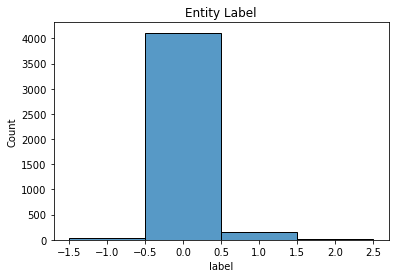

In [339]:
plotc = sns.histplot(df2_train[df2_train['entity']== '中国'].label,discrete=True)
plotc.set(title = "Entity Label")
fig4 = plot.get_figure()
fig4.savefig("label.png")

#### 测试数据

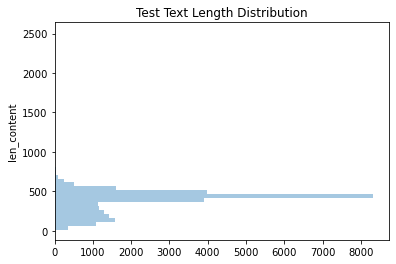

In [320]:
dplot2 = sns.distplot(df_test['len_content'],kde=False,vertical=True)
dplot2.set(title = "Test Text Length Distribution")
fig2 = dplot2.get_figure()
fig2.savefig("test_len.png")

In [325]:
c = df_test.loc[:,'len_content'].value_counts() #统计len_content这一列每个元素出现的个数
d = c.idxmax()  # 找出最多的文本长度
print(d)

404


In [327]:
print('测试数据文本最长长度：', max(df_test['len_content']))
print('测试数据文本最短长度：', min(df_test['len_content']))
print('训练数据文本出现最多次的长度：', d)

测试数据文本最长长度： 2517
测试数据文本最短长度： 12
训练数据文本出现最多次的长度： 404


In [ ]:
count_csv2 = df2_test['entity'].value_counts()  
print(count_csv2)
count_csv2.to_csv("test_count.csv",mode='a')

中国         1383
美国         1033
北京          374
日本          368
粉丝          337
           ... 
南康            1
斯中商务          1
孙殿英           1
科学出版社         1
铁齿铜牙纪晓岚       1
Name: entity, Length: 13505, dtype: int64


In [473]:
#测试集出现次数最多的entity
count_csv2.index[:10]
entity_test = count_csv2.index.tolist()
print(entity_test[:10])

['中国', '美国', '北京', '日本', '粉丝', '病例', '湖人', '詹姆斯', '台湾', '俄罗斯']


In [69]:
import json
def new_data_piece(id: int, content: str, entity: dict,
                   label: int,is_train:bool) -> dict:
    if is_train:
        return {
            "id": id,
            "content": content,
            "entity": entity,
            "label": label,
        }
    else:
        return {
            "id": id,
            "content": content,
            "entity": entity
        }

with open(os.path.join('s-train.txt'), 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines:
        taskData = json.loads(line.strip())
        contents = taskData['content']
        entitys = taskData['entity']
        id = taskData["id"]
        for entity, label in entitys.items():
            data = new_data_piece(id, content=contents,entity=entity, label=int(label),is_train=True)

In [42]:
for line in f:
    if is_test == False:
        yield {'content': line[0], 'entity': line[1], 'label': line[2]}
    else:
        yield {'content': line[0], 'entity': line[1]}

ValueError: DataFrame constructor not properly called!